### Preliminary analysis of scRNA-seq data for Foxp3 degradation in Treg cells

We will run DESeq twice; first to filter out any genes differential at D0 (no drug added), and then a second time to get the DEGs for D3 and D7. In this notebook, we deal with creating matrices for the second pass of DESeq2, as well as some of the downstream analysis.

In [1]:
%load_ext autoreload
import scanpy as sc

In [2]:
sc.set_figure_params(figsize=(5,5)) # no blurry figures allowed
sc.settings.verbosity = 4  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [3]:
%autoreload 2 

import sys
sys.path.append('./code/')
from init_global_vars import *
import matplotlib.pyplot as plt
import seaborn as sns

## Load and preprocess data

In [4]:
adata = sc.read('adatas/without_d0_filter.h5ad')

#### Filter genes

We are removing any genes which are differential at D0 (untreated cells); these are not biologically relevant and only due to genotype differences

In [5]:
%autoreload 2
from init_bulk_RNA import *

(sc_rna_lfc_df, sc_rna_pval_df, 
 sc_rna_basemean_df, sc_rna_wald_df) = load_lfc_and_pval_df('./bulk_rna_data/DESeq2/output/scINIT*thresh=0.csv')

pco = .15
d0_degs = sc_rna_pval_df.index[(sc_rna_pval_df['scINIT_rest_D0_tir1_vs_D0_wt'] < pco) 
                             | (sc_rna_pval_df['scINIT_active_D0_tir1_vs_D0_wt'] < pco)
                              ]
adata = adata[:, ~adata.var.index.isin(d0_degs)]

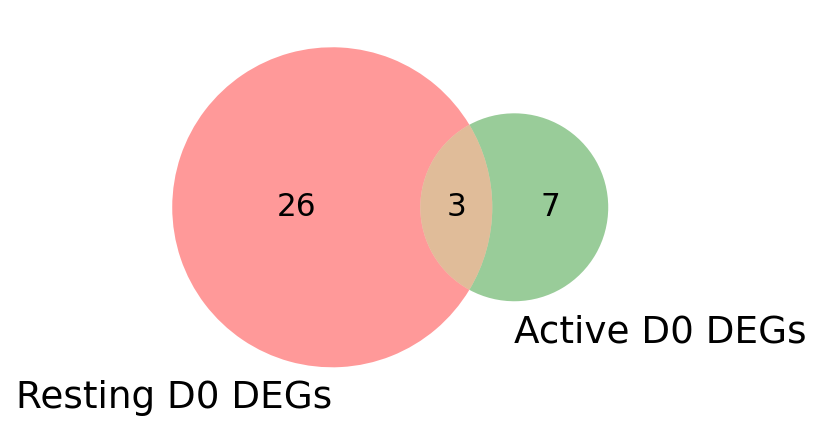

In [6]:
from matplotlib_venn import venn2
rest_d0_degs = set(sc_rna_pval_df.index[(sc_rna_pval_df['scINIT_rest_D0_tir1_vs_D0_wt'] < pco)])
actv_d0_degs = set(sc_rna_pval_df.index[(sc_rna_pval_df['scINIT_active_D0_tir1_vs_D0_wt'] < pco)])
      
venn2([rest_d0_degs, actv_d0_degs], ['Resting D0 DEGs', 'Active D0 DEGs'])


#### Re-run PCA, etc. without D0 DEGs confounding

In [7]:
from aux_functions_scRNA import *

n_pcs = 100
sc.tl.pca(adata, n_comps=n_pcs, svd_solver='arpack')
# we like cosine similarity more so than Euclidean (better silhouettes once clustering)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs, use_rep='X_pca', metric="cosine")
sc.tl.leiden(adata, resolution = 1)
sc.tl.umap(adata)

agg = aggregate_adata_by_obs_column(adata, key='leiden', layer='theta_10')

computing PCA
    with n_comps=100
    finished (0:00:37)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Genomics/argo/users/g

    computed neighbors (0:00:28)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:36)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:21)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:38)


#### Visualize final UMAP

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


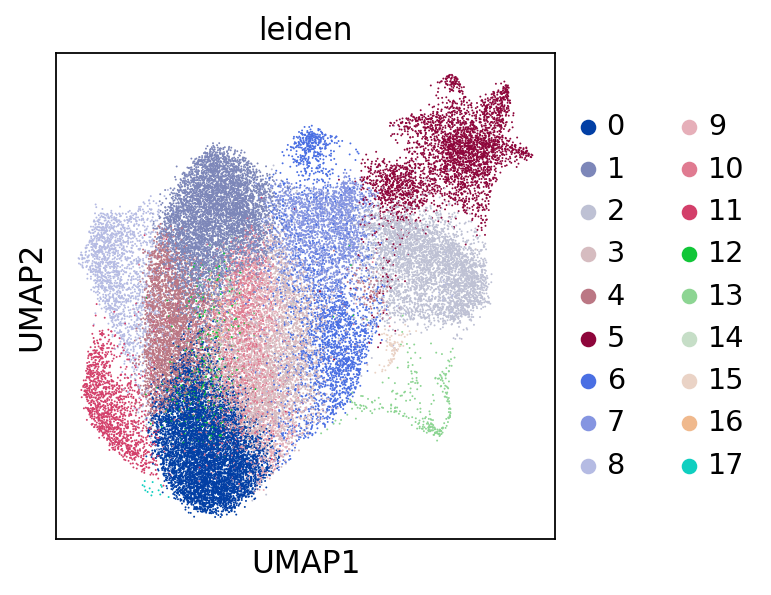

In [8]:
sc.pl.umap(adata, color = ['leiden'], cmap = 'coolwarm', vmax = 1, vmin = -1)

### Plotting functions

Initializing different functions for plotting adata objects

In [9]:
from plotting_functions import init_subplots_exact
PLOT_ORDER_BAR = ['D7_wt', 'D3_wt', 'D0_wt', 'D0_tir1', 'D3_tir1', 'D7_tir1']
def plot_clusters_for_adata(adata, sample_key='sample', cluster_key='leiden'):
    import seaborn as sns
    colors = sns.color_palette('coolwarm', n_colors=7)
    sample_to_color = {}
    sample_to_number = {}
    for i in adata.obs[sample_key].unique():
        #name, rep = i.split("_rep")
        name = i
        if 'D0_tir1' in name:
            color = '#dddcdc'
        elif 'D3_tir1' in name:
            color = '#a0ebb4'
        elif 'tir' in name:
            color = '#00CC99'
        elif 'D3_wt' in name:
            color = '#FFA467'
        elif 'D0_wt' in name:
            color = '#FFD2B3'
        else:
            color = '#FF6600'
        base = np.where(arr(PLOT_ORDER_BAR)==name)[0][0]
        sample_to_number[i] = base #+ int(rep)
        sample_to_color[i] = color

    freq_matrix = adata.obs.groupby([cluster_key, sample_key]).size().unstack()
    freq_matrix = (freq_matrix.T/freq_matrix.sum(axis=1)).T
    freq_matrix = freq_matrix.iloc[:, np.argsort(freq_matrix.columns.str.contains("wt"))]
    freq_matrix = freq_matrix.iloc[:, np.argsort([sample_to_number[x] for x in freq_matrix.columns])]

    count_matrix = adata.obs.groupby([cluster_key, sample_key]).size().unstack()
    count_matrix = count_matrix.iloc[:, np.argsort(freq_matrix.columns.str.contains("wt"))]
    count_matrix = count_matrix.iloc[:, np.argsort([sample_to_number[x] for x in freq_matrix.columns])]

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style('ticks')
    colors = sns.color_palette('coolwarm', n_colors=7)

    fig, ax = plt.subplots(figsize=(12, 4))
    freq_matrix.plot.bar(stacked=True, ax=ax, color=[sample_to_color[x] for x in freq_matrix.columns],
                        linewidth=.25, edgecolor='black')
    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
    ax.set_ylabel("Cluster composition")

    plt.xticks(rotation=0)
    # Create an inset axes for scatter plot
    # Position: [left, bottom, width, height] in figure coordinates (from 0 to 1)
    tmpax = ax.inset_axes(transform=ax.transAxes,
        bounds = (0, -.35, 1, .1))
    for spine in tmpax.spines:
        tmpax.spines[spine].set_visible(False)
    tmpax.set_yticks([])
    tmpax.set_xticks([])    
    tmpax.set_xlim(ax.get_xlim())
        
    counts = count_matrix.sum(axis=1)
    xs = counts.index
    ys = counts.values
    tmpax.scatter(xs, ys/ys*-1, s = ys/20, color='black', marker='o', label='# Cells', 
               )
#     plt.ylim([0, 1.1])
#     ax2.legend(bbox_to_anchor=(1.1, .4), loc='upper left')
#     ax2.set_ylabel("# of cells")
    ax.set_title(f"Cluster composition for leiden clusters (RNA standalone), {cluster_key}")
    return fig

def make_stripplot_by_sample():
    s = adata.obs.value_counts(['sample', 'leiden']).unstack()
    s = s.div(s.sum(axis=1), axis=0)
    
    s = s.fillna(0).reset_index()
    s['day'] = [x.split("_")[0] for x in s['sample']]
    s['tir1'] = [x.split("_")[1] for x in s['sample']]
    
    clusts = adata.obs['leiden'].cat.categories
    n = len(clusts)
    fig, axs = init_subplots_exact(n, 5, fgsz=(3, 3), dpi = 150, sharey=True, xspace=1.4, yspace=1.4)
    for c, col in enumerate(clusts):
        subdf = s[[col, 'day', 'tir1']]
        plt.sca(axs[c])
        if c == 0:
            legend = True
        else:
            legend = False
        sns.stripplot(data=subdf, x='day', hue='tir1', y=col, s = 8, legend=legend)
        plt.ylabel("Frac. in leiden")
        plt.title(f'Leiden = {col}')

def make_active_resting_cutoffs(adata, active_cutoff=.5, resting_cutoff = -.25):

    
    adata.obs['cell_is_active'] = cutoff_vector(adata.obs['Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5'], active_cutoff).astype(int)
    adata.obs['cell_is_resting'] = (cutoff_vector(adata.obs['Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5'], resting_cutoff) & (~ adata.obs['cell_is_active'])).astype(int)
    
    adata.obs.loc[adata.obs['cell_is_resting']==1, 'cell_is_resting_plot'] = 'Resting'
    adata.obs.loc[adata.obs['cell_is_resting']==0, 'cell_is_resting_plot'] = 'Not resting'
    adata.obs.loc[adata.obs['cell_is_active']==1, 'cell_is_active_plot'] = 'Active'
    adata.obs.loc[adata.obs['cell_is_active']==0, 'cell_is_active_plot'] = 'Not active'
    
    adata.obs['cluster_is_active'] = (adata.obs['Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5'] > np.inf).astype(int)
    adata.obs['cluster_is_resting'] = (adata.obs['Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5'] > np.inf).astype(int)
    for u in np.unique(adata.obs['leiden']):    
        val = adata[adata.obs['leiden'] == u].obs['Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5'].mean()
        if val > .1:
            adata.obs.loc[adata.obs['leiden'] == u, 'cluster_is_resting'] = 'Resting'
        else:
            adata.obs.loc[adata.obs['leiden'] == u, 'cluster_is_resting'] = "Not resting"
            
        val = adata[adata.obs['leiden'] == u].obs['Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5'].mean()
        if val > .1:
            adata.obs.loc[adata.obs['leiden'] == u, 'cluster_is_active'] = "Active"
        else:
            adata.obs.loc[adata.obs['leiden'] == u, 'cluster_is_active'] = "Not active"
    
    adata.obs['cell_is_not_active_or_resting'] = ~((adata.obs['cell_is_resting']>0) | (adata.obs['cell_is_active']>0))


    
    fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=False)
    keys = ['Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5', 'Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5']
    for c, key in enumerate(keys):
        sns.histplot(adata.obs[key], ax=axs[c], zorder=1)
        axs[c].set_title(' '.join(key.split("_")[:2]) + " signature")
    
    for ax in axs:
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([0, 1500])
    axs[0].axvspan(compute_cutoff(adata.obs[keys[0]], active_cutoff), 1.5, color='gray', alpha=.2, zorder=-1, label='Included')
    axs[1].axvspan(compute_cutoff(adata.obs[keys[1]], resting_cutoff), 1.5, color='gray', alpha=.2, zorder=0, label='Included')
    axs[0].set_xlabel("Score")
    axs[1].set_xlabel("Score")
    axs[0].legend()
    axs[1].legend()
    plt.tight_layout()
    fig.savefig('./FINAL_FIGURES/active_rest_hist.pdf', bbox_inches='tight')

def plot_total_active_resting_number(adata, sample_key='sample', activation_key_dict={}):
    all_matrices = pd.DataFrame()
    for name, activation_key in activation_key_dict.items():
        count = (adata.obs[activation_key] > 0).sum()
        all_matrices[name] = [count]

    all_matrices = pd.DataFrame(all_matrices)

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style('ticks')
    colors = sns.color_palette('coolwarm', n_colors=7)

    n = len(activation_key_dict)
    meltdf = all_matrices.melt()

    print(meltdf)
    meltdf = meltdf.sort_values("value", ascending=False)
    fig, ax = plt.subplots(figsize=(3, 4))
    sns.barplot(data = meltdf, x='variable', y='value', ax=ax, palette='viridis', hue_order = [])
    ax.set_ylabel("Count")
    ax.set_xlabel("Status")
    ax.set_title("Active/Resting Counts")
    return fig

import matplotlib.patches as mpatches

def deduplicate_legend(ax, legend):
    new_handles = []
    new_labels = []
    existing_colors = {}
    for handle, label in zip(legend.legendHandles, legend.texts):
        if isinstance(handle, mpatches.Rectangle):
            color = handle.get_fc()
        else:
            color = handle.get_facecolor()[0]
        color_tuple = tuple(color)

        if color_tuple not in existing_colors:
            existing_colors[color_tuple] = 1
            new_handles.append(handle)
            new_labels.append(' '.join(label.get_text().split("_")[:2]))
    ax.legend(new_handles, new_labels, bbox_to_anchor=(1, 1), loc='upper left')
    
def plot_clusters_for_active_resting(adata, sample_key='sample', activation_key_dict={}):
    import seaborn as sns
    colors = sns.color_palette('coolwarm', n_colors=7)
    sample_to_color = {}
    sample_to_number = {}
    for i in adata.obs[sample_key].unique():
        #name, rep = i.split("_rep")
        name = i
        if 'D0_tir1' in name:
            color = '#dddcdc'
        elif 'D3_tir1' in name:
            color = '#a0ebb4'
        elif 'tir' in name:
            color = '#00CC99'
        elif 'D3_wt' in name:
            color = '#FFA467'
        elif 'D0_wt' in name:
            color = '#FFD2B3'
        else:
            color = '#FF6600'
        base = np.where(arr(PLOT_ORDER_BAR)==name)[0][0]
        sample_to_number[i] = base #+ int(rep)
        sample_to_color[i] = color

    all_matrices = []
    for name, activation_key in activation_key_dict.items():
        subadata = adata[adata.obs[activation_key] > 0]
        freq_matrix = subadata.obs.groupby([sample_key]).size()#.unstack()
        freq_matrix.name = name
        freq_matrix = freq_matrix/freq_matrix.sum()
        all_matrices.append(freq_matrix)

    all_matrices = pd.DataFrame(all_matrices)
    all_matrices = all_matrices.iloc[:, np.argsort(all_matrices.columns.str.contains("wt"))]
    all_matrices = all_matrices.iloc[:, np.argsort([sample_to_number[x] for x in all_matrices.columns])]

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style('ticks')
    colors = sns.color_palette('coolwarm', n_colors=7)

    n = len(activation_key_dict)
    fig, ax = plt.subplots(figsize=(3*n, 4))
    all_matrices.plot.barh(stacked=True, ax=ax, color=[sample_to_color[x] for x in all_matrices.columns])
    leg = ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
    deduplicate_legend(ax, leg)
    ax.set_ylabel("Status")
    ax.set_xlabel("Fraction")
    ax.set_xlim([0, 1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("Composition of active/resting cells")
    return fig

def make_stripplot_by_active_rest(key):
    s = adata.obs.value_counts(['sample', key]).unstack()
    s = s.div(s.sum(axis=1), axis=0)
    
    s = s.fillna(0).reset_index()
    s['day'] = [x.split("_")[0] for x in s['sample']]
    s['tir1'] = [x.split("_")[1] for x in s['sample']]
    
    clusts = adata.obs[key].unique()
    n = len(clusts)
    fig, axs = init_subplots_exact(n, 1, fgsz=(3, 3), dpi = 150, sharey=False, xspace=1.4, yspace=1.4)
    for c, col in enumerate(clusts):
        subdf = s[[col, 'day', 'tir1']]
        plt.sca(axs[c])
        if c == 0:
            legend = True
        else:
            legend = False
        sns.stripplot(data=subdf, x='day', hue='tir1', y=col, s = 8, legend=legend)
        plt.ylabel("Frac. in condition")
        plt.title(f'Condition: {col}')

#### Plot composition of leiden clusters by condition – roughly the same for all conditions

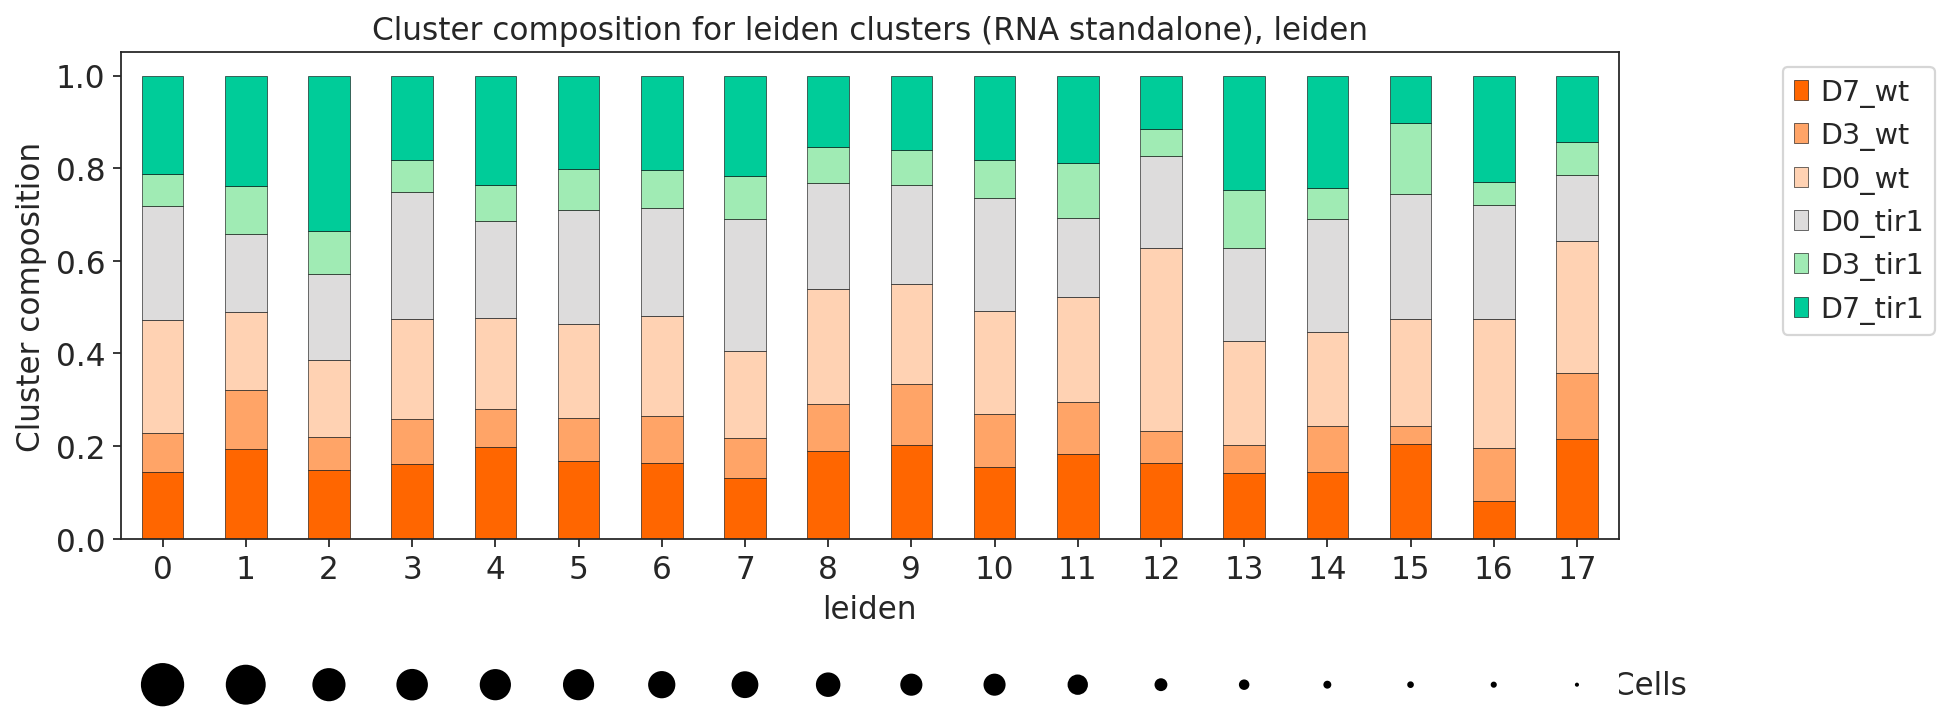

In [10]:
f = plot_clusters_for_adata(adata, sample_key='dereplicate_sample', cluster_key='leiden')    
plt.text(17, -.35, "# Cells", va='bottom')

f.savefig('./FINAL_FIGURES/leiden_cluster_proportions.pdf', bbox_inches='tight')

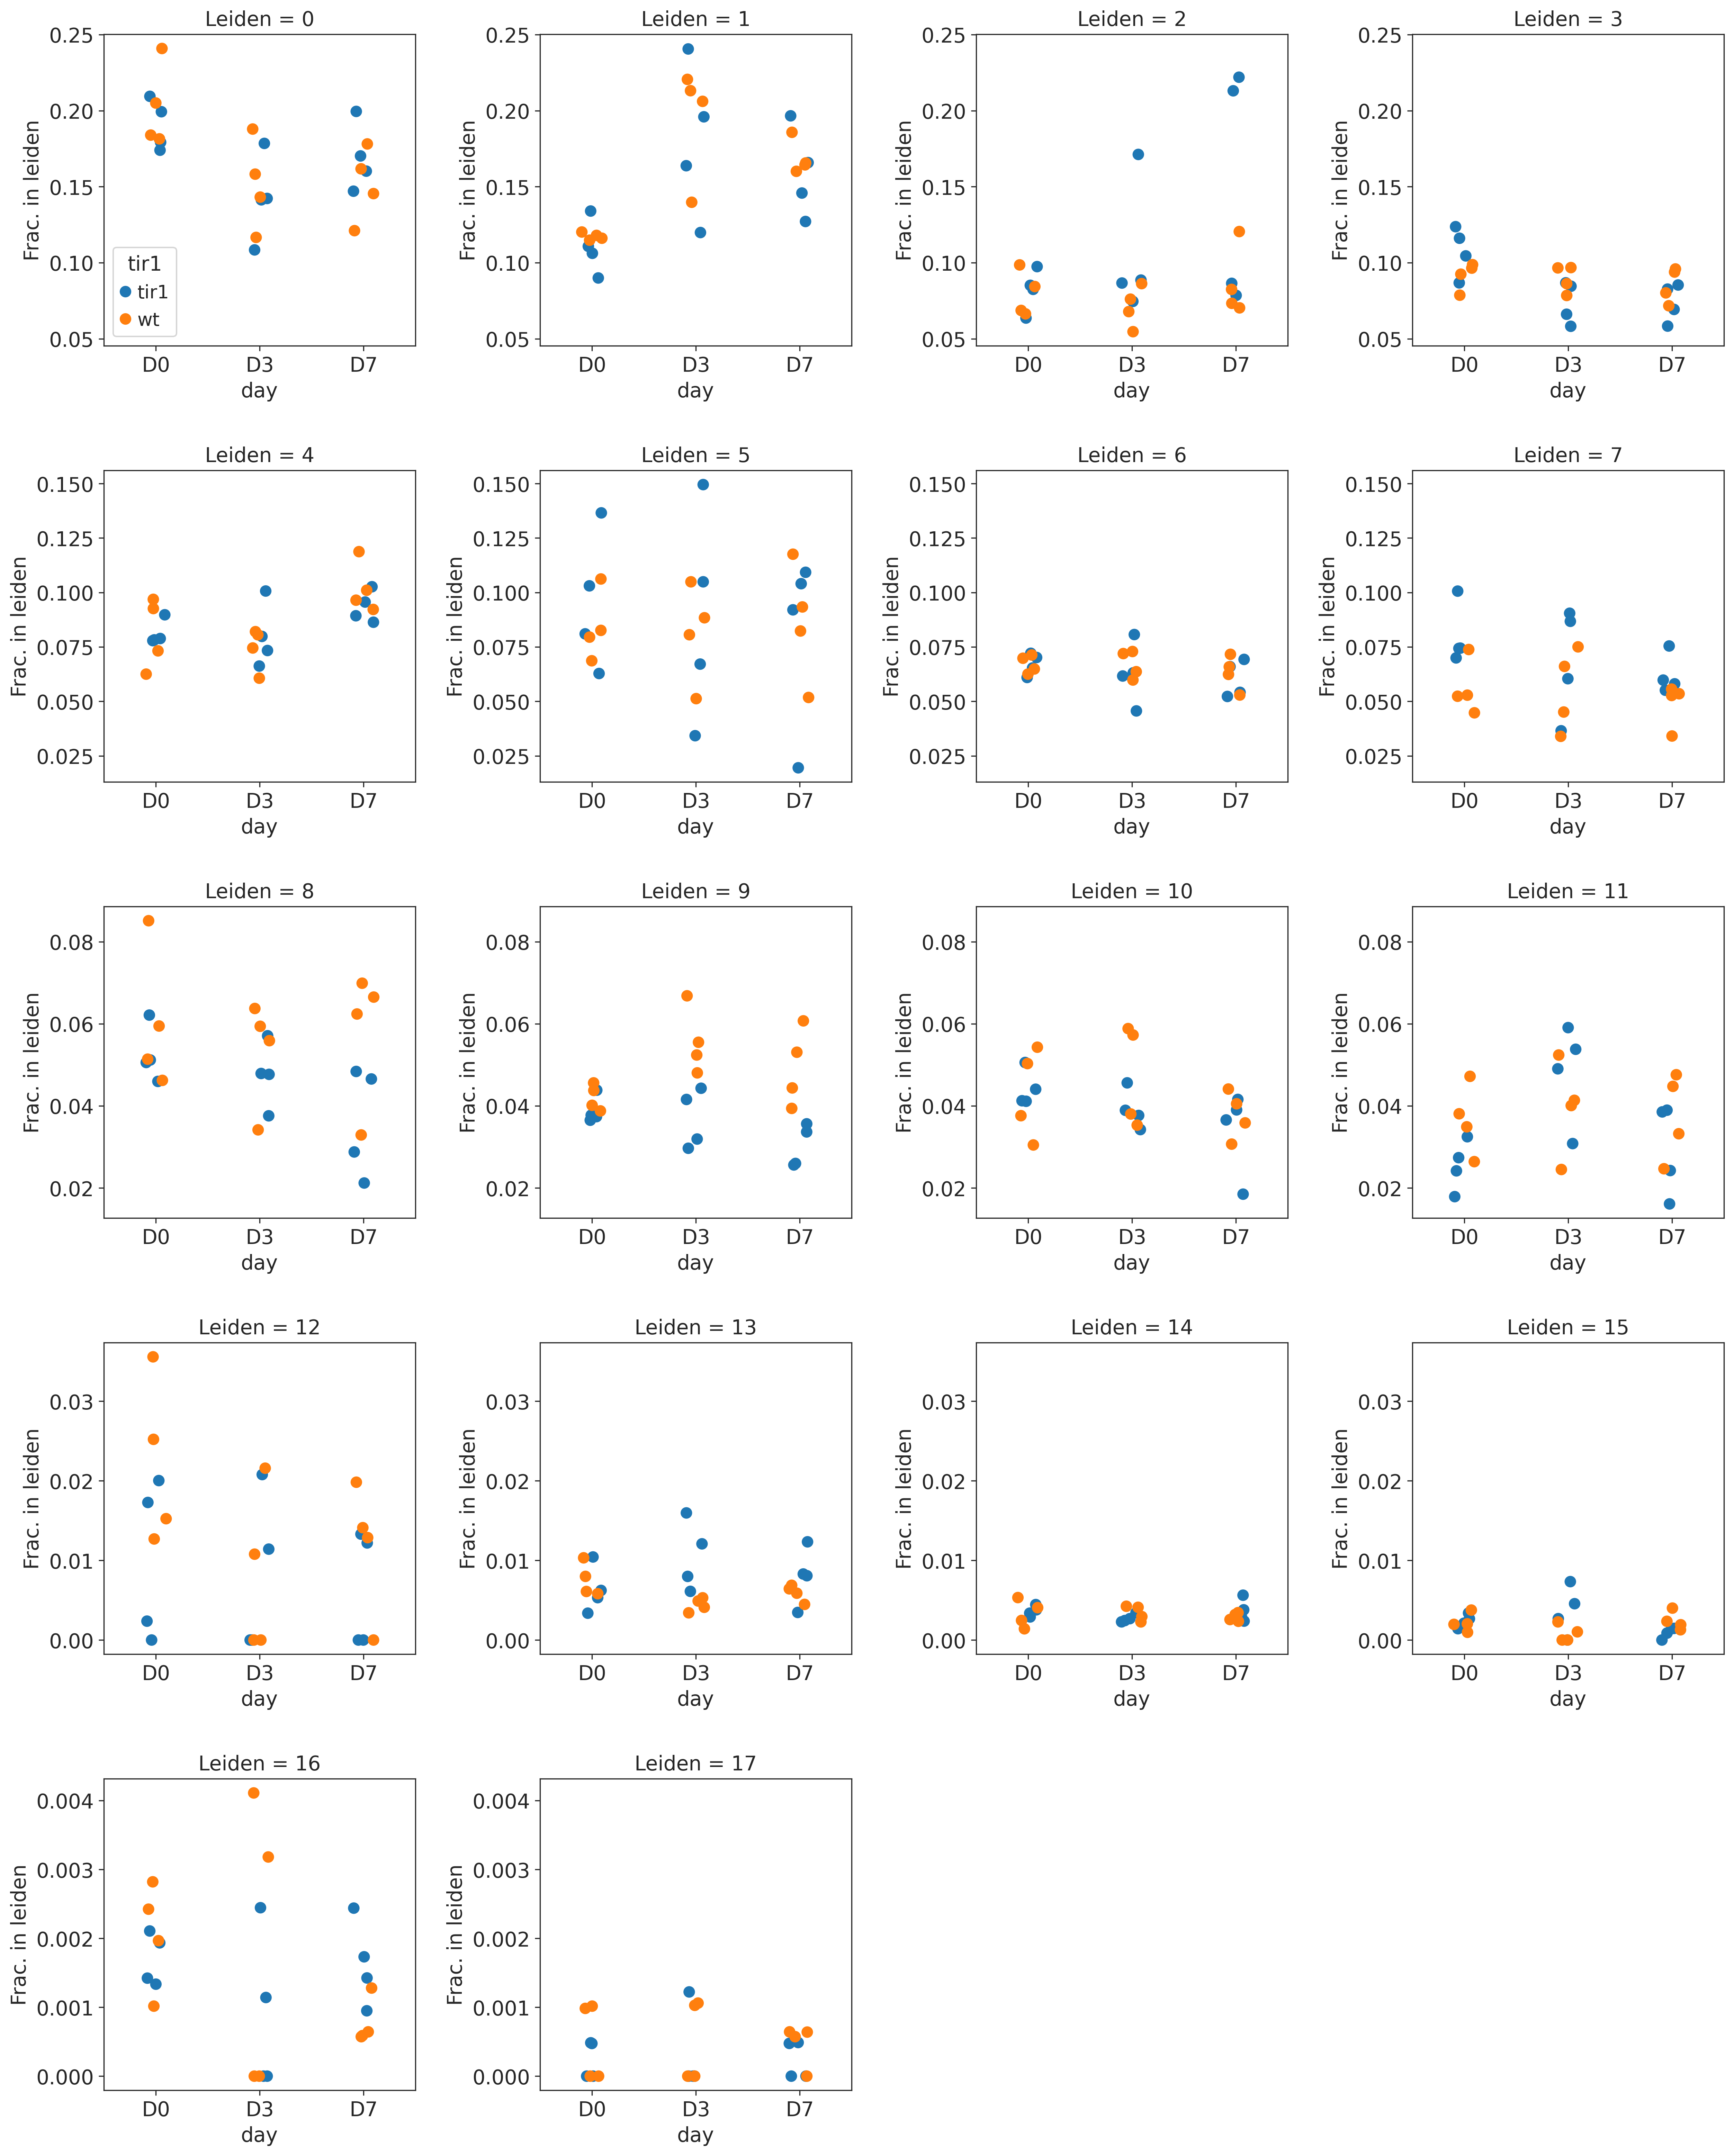

In [11]:
make_stripplot_by_sample()

#### D7 Tir1 vs D7 WT UMAP

Show presence/absence of D7 WT and D7 Tir1 over the final UMAP

In [12]:
adata.obs['is_d7_tir1_str'] = adata.obs['is_d7_tir1'].copy()
adata.obs.loc[adata.obs['is_d7_tir1_str'] == 1, 'is_d7_tir1_str'] = 'D7 Tir1'
adata.obs.loc[adata.obs['is_d7_tir1_str'] == 0, 'is_d7_tir1_str'] = 'Other'

adata.obs['is_d7_wt_str'] = adata.obs['is_d7_wt'].copy()
adata.obs.loc[adata.obs['is_d7_wt_str'] == 1, 'is_d7_wt_str'] = 'D7 WT'
adata.obs.loc[adata.obs['is_d7_wt_str'] == 0, 'is_d7_wt_str'] = 'Other'

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


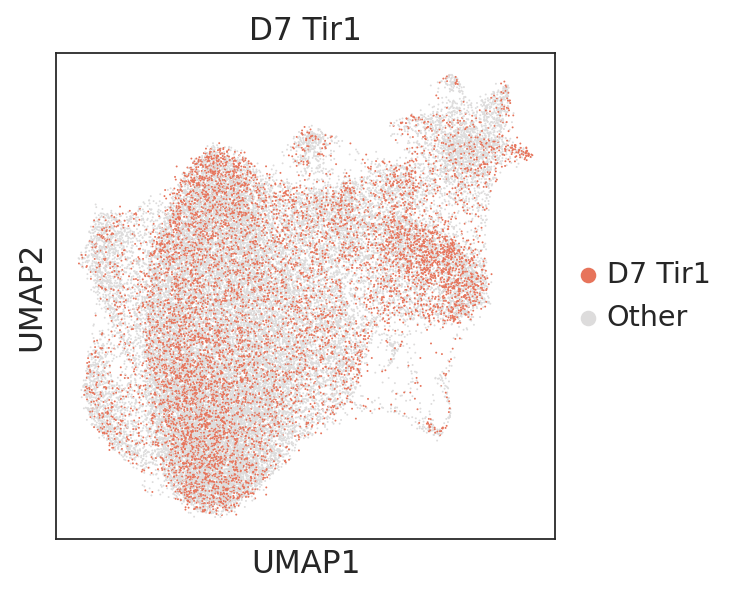

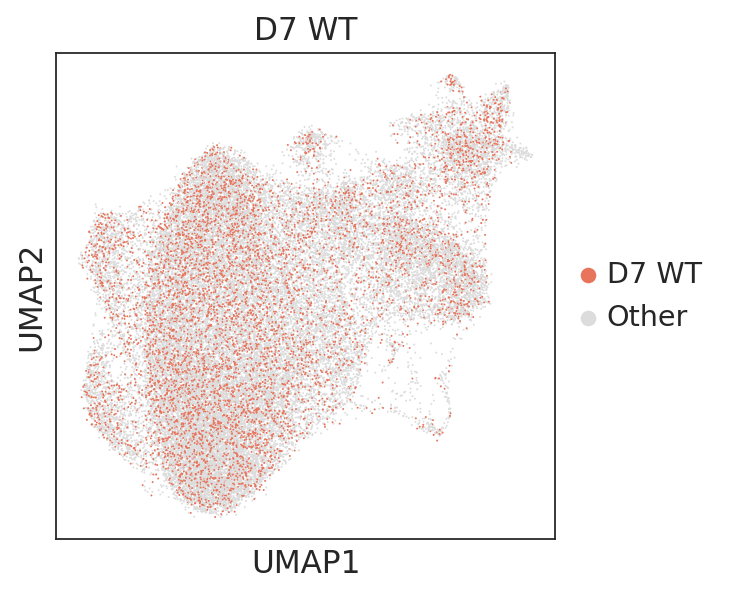

In [13]:
d7_wt_palette = [sns.color_palette('coolwarm', n_colors=5)[4], sns.color_palette('coolwarm', n_colors=5)[2]]
fig = sc.pl.umap(adata, color=['is_d7_tir1_str'], palette = d7_wt_palette, vmin=-1, title='D7 Tir1', return_fig=True)
fig.savefig('./FINAL_FIGURES/d7_tir1_umap.pdf', bbox_inches='tight', dpi = 400)
fig = sc.pl.umap(adata, color=['is_d7_wt_str'], palette = d7_wt_palette, vmin=-1, title='D7 WT', return_fig=True)
fig.savefig('./FINAL_FIGURES/d7_wt_umap.pdf', bbox_inches='tight', dpi = 400)

### Recalculate activated/resting cells

Recalculate the active/resting cells in the final adata object

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


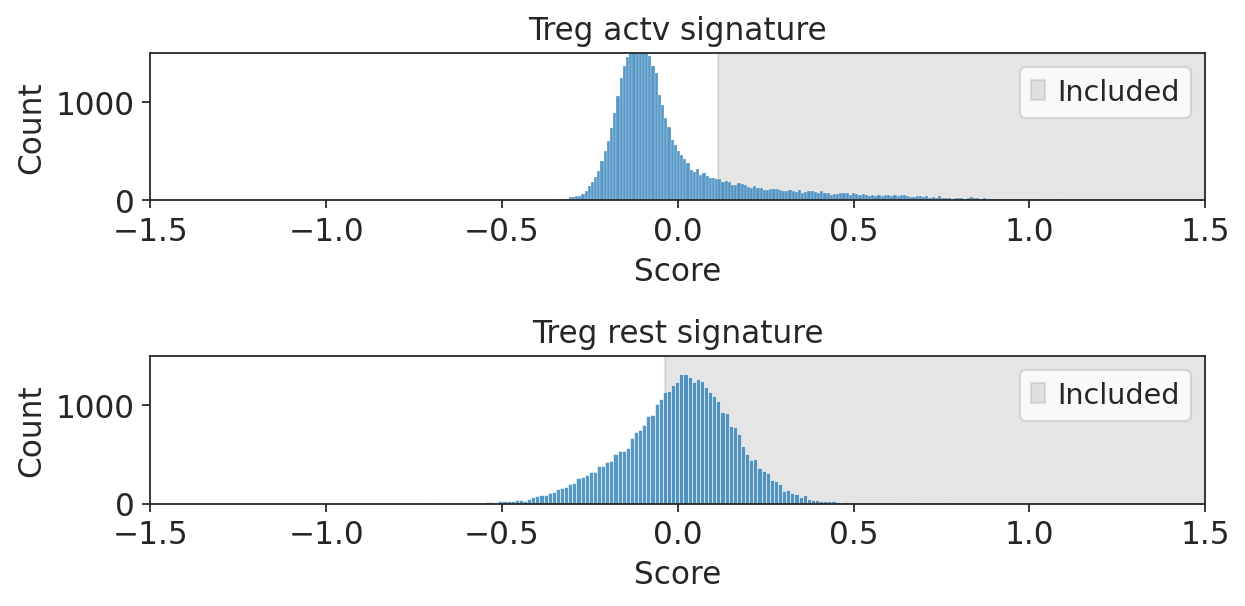

In [14]:
%load_ext autoreload
%autoreload  2
import sys
sys.path.append('./code')
from aux_functions_scRNA import *

make_active_resting_cutoffs(adata)

#### Pass count data to DESeq2

Save this to re-run DESeq2 on the cleaned adata

In [15]:
active_counts = make_df_aggregated_by_key(adata, adata.var.index, key='sample', 
                          leiden='cell_is_active', layer='raw_counts', 
                          useLog=False,
                          pc=0, agg_func=np.sum)

resting_counts = make_df_aggregated_by_key(adata, adata.var.index, key='sample', 
                          leiden='cell_is_resting', layer='raw_counts', 
                          useLog=False, 
                          pc=0, agg_func=np.sum)

count_rest_df = resting_counts[resting_counts['cell_is_resting'] > 0
              ].pivot(index='gene', columns=['sample'], values='value')

count_actv_df = active_counts[active_counts['cell_is_active'] > 0
              ].pivot(index='gene', columns=['sample'], values='value')

col_data = pd.DataFrame(count_rest_df.columns.str.replace("_rep[0-9]", '', regex=True), index=list(count_rest_df.columns))

count_rest_df.to_csv('./bulk_rna_data/DESeq2/sc_counts_FINAL/count_rest_df.csv')
count_actv_df.to_csv('./bulk_rna_data/DESeq2/sc_counts_FINAL/count_active_df.csv')
col_data.to_csv('./bulk_rna_data/DESeq2/sc_counts_FINAL/colData.csv')

### Active/Resting plots

Here we are plotting the active/resting cells over the UMAP

In [16]:
from matplotlib.colors import LinearSegmentedColormap

active_resting_palette = {
    'Active' : sns.color_palette('coolwarm', n_colors=7)[5],
    'Not active' : sns.color_palette('coolwarm', n_colors=7)[3],
    'Resting' : sns.color_palette('coolwarm', n_colors=7)[5],
    'Not resting' : sns.color_palette('coolwarm', n_colors=7)[3],
}

coolwarm = plt.cm.get_cmap('coolwarm')

# Define the start and end of the middle part (e.g., 0.25 to 0.75 for the middle half)
start, end = 0.5, 1

# Create a new colormap from the middle part of coolwarm
middle_colors = coolwarm(np.linspace(start, end, 256))
middle_coolwarm = LinearSegmentedColormap.from_list("middle_coolwarm", middle_colors)

/tmp/ipykernel_2396015/1518503477.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  coolwarm = plt.cm.get_cmap('coolwarm')


In [17]:
def active_resting_umap(adata):
    axs = sc.pl.umap(adata, color=[
                             'Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5', 
                             'Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5',
                             'cell_is_resting_plot', 'cell_is_active_plot'
                            ], 
                     vmax=[.2, .4, 1, 0], 
                     vmin=[-.1, -.1, -2, -2], cmap=middle_coolwarm,
              title = ['Treg Resting Signature Score', 
                       'Treg Active Signature Score',
                       'Resting Cells',
                       'Active Cells',
                      ],
               palette = active_resting_palette,
               ncols = 2,
               wspace = .4, show=False,
                     
              )
    
    for ax in axs[2:]:
        plt.sca(ax)
        legend = plt.gca().get_legend()
        new_order = [1, 0]  # Change this to your desired order
        new_handles = [legend.legendHandles[i] for i in new_order]
        new_labels = [legend.texts[i].get_text() for i in new_order]
        legend.remove()
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=handle.get_facecolor(), markersize=10, markeredgewidth=0.5, ) for handle, label in zip(new_handles, new_labels)]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.5), loc='center left', fontsize='small', frameon=False)

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_2396015/495889992.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  new_handles = [legend.legendHandles[i] for i in new_order]


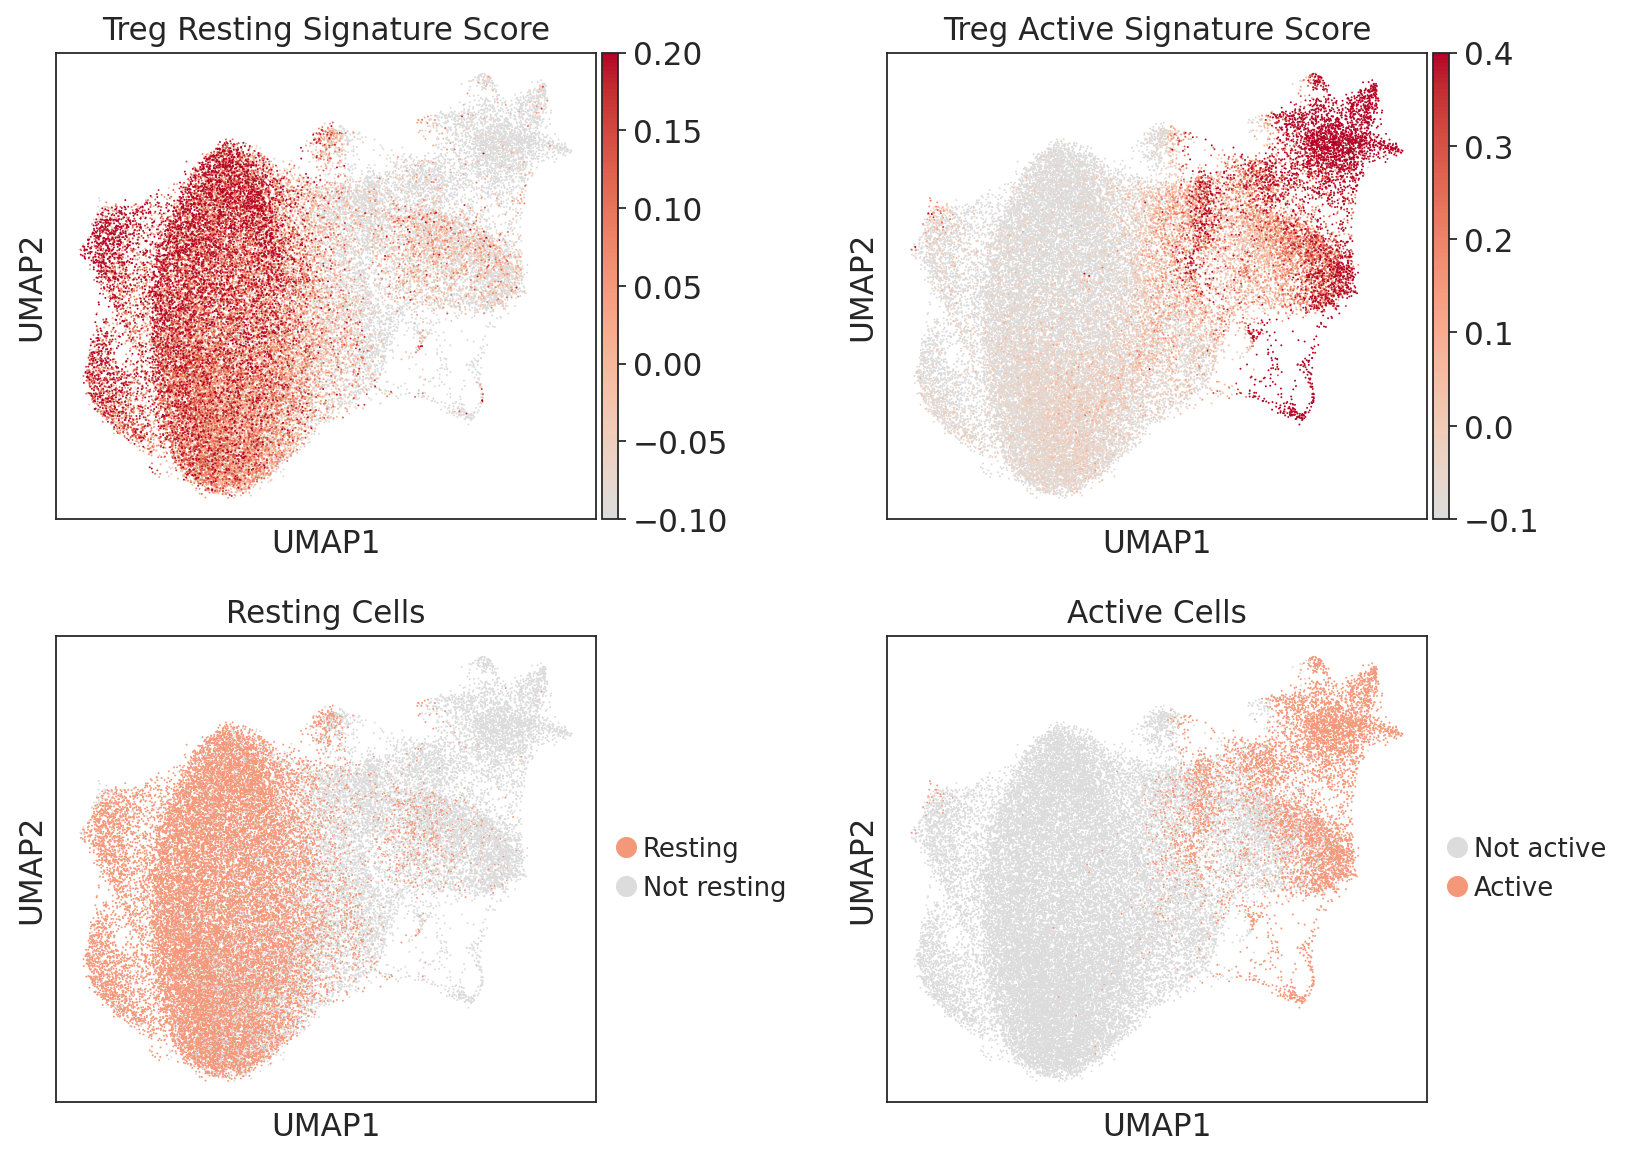

In [18]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

active_resting_umap(adata)
plt.gcf().savefig('./FINAL_FIGURES//active_resting_UMAP.pdf', bbox_inches='tight')

Plot the total number of active/resting

  variable  value
0  Resting  24211
1   Active   6731
2  Neither   8314


/tmp/ipykernel_2396015/3659042580.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = meltdf, x='variable', y='value', ax=ax, palette='viridis', hue_order = [])


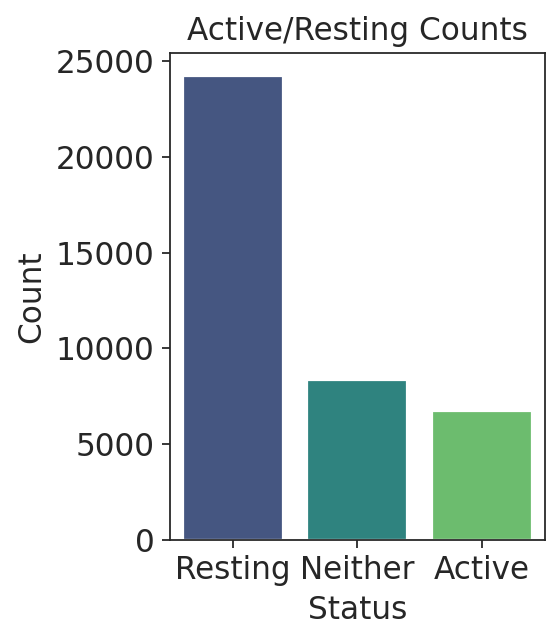

In [19]:
fig = plot_total_active_resting_number(adata, activation_key_dict = {
                                                               'Resting' : 'cell_is_resting', 
                                                               'Active' : 'cell_is_active',
                                                               'Neither' : 'cell_is_not_active_or_resting',
                                                              })
fig.savefig('./FINAL_FIGURES/active_resting_neither_count.pdf', bbox_inches='tight')

Plot active/resting by condition

/tmp/ipykernel_2396015/3659042580.py:170: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle, label in zip(legend.legendHandles, legend.texts):


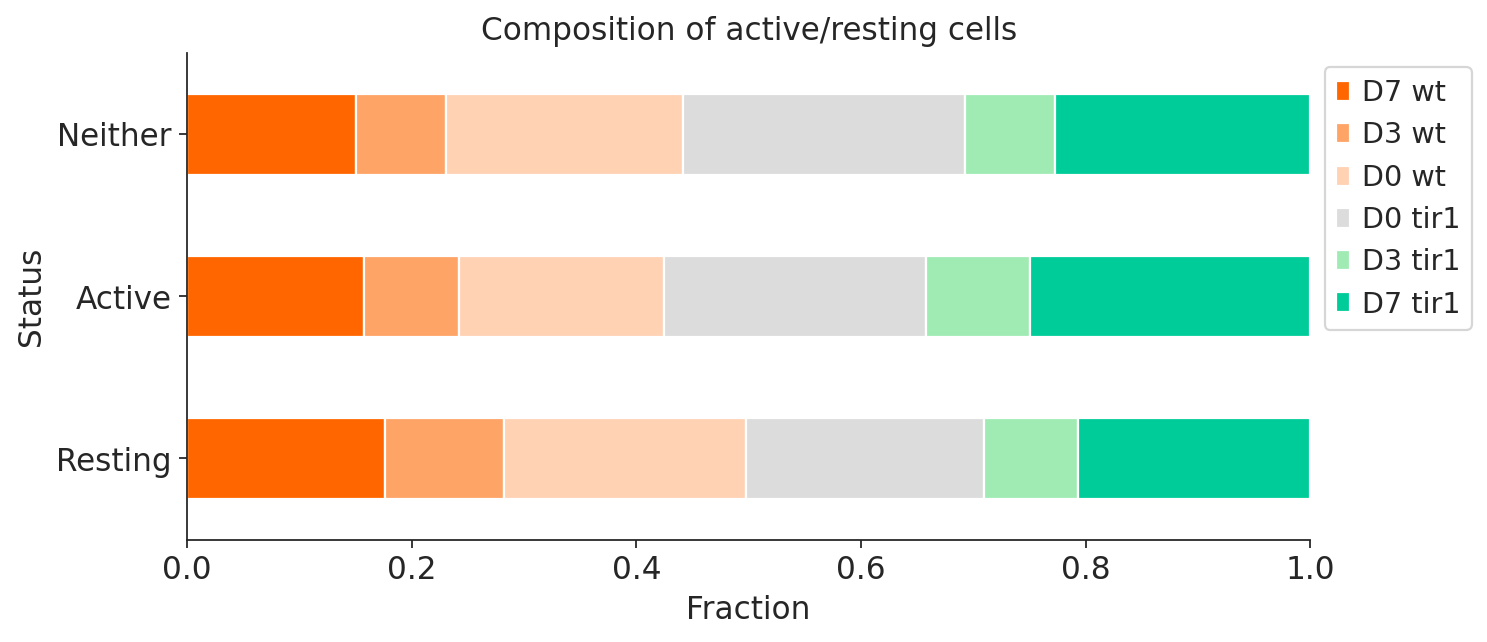

In [20]:
fig = plot_clusters_for_active_resting(adata, sample_key='dereplicate_sample', activation_key_dict = {
                                                               'Resting' : 'cell_is_resting', 
                                                               'Active' : 'cell_is_active',
                                                               'Neither' : 'cell_is_not_active_or_resting',
                                                              })
fig.savefig('./FINAL_FIGURES//active_resting_neither_condition_composition.pdf', bbox_inches='tight')

Visualize this as a stripplot

In [21]:
adata.obs['status'] = adata.obs['cell_is_resting']
adata.obs.loc[adata.obs['cell_is_resting']>0, 'status'] = 'resting'
adata.obs.loc[adata.obs['cell_is_active']>0, 'status'] = 'active'
adata.obs.loc[adata.obs['cell_is_not_active_or_resting']>0, 'status'] = 'neither'

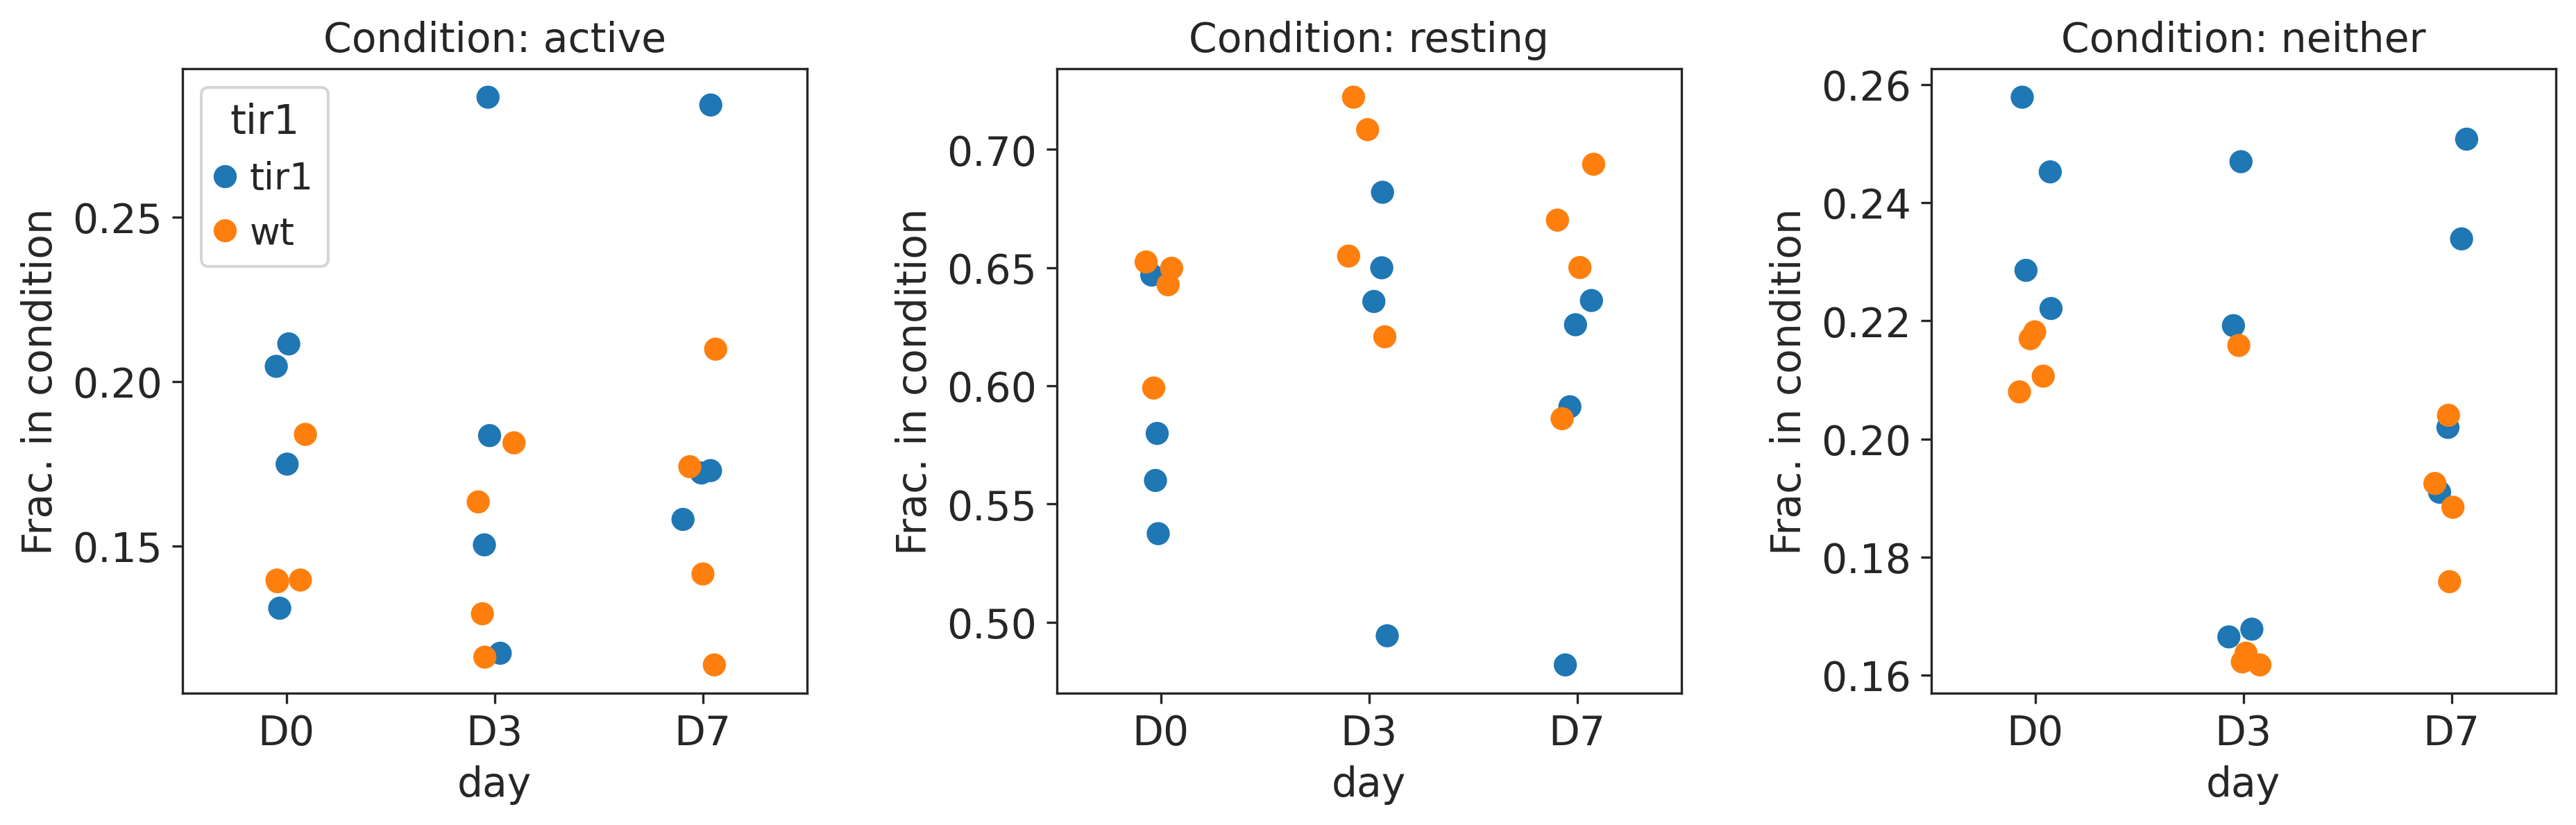

In [22]:
make_stripplot_by_active_rest('status')

We found that after extremely high levels of leiden clustering, Il17a was higher in some parts of the UMAP, and slightly enriched in Tir1

In [23]:
sc.tl.leiden(adata, resolution=5, key_added='leiden_res=5')

running Leiden clustering
    finished: found 64 clusters and added
    'leiden_res=5', the cluster labels (adata.obs, categorical) (0:00:25)


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


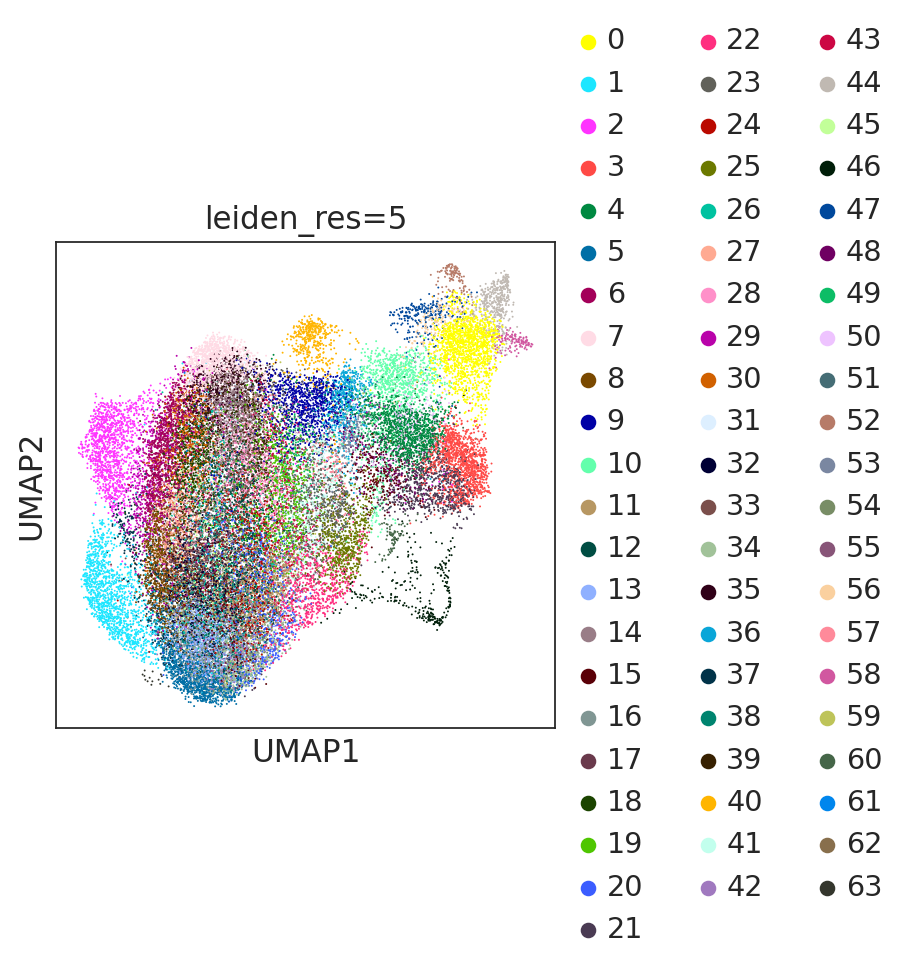

In [24]:
sc.pl.umap(adata, color='leiden_res=5')

In [25]:
from aux_functions_scRNA import *

agg = aggregate_adata_by_obs_column(adata, key='leiden_res=5', layer='theta_10')
# Select the cluster corresponding to highest Il17a expression
cluster_with_il17 = agg.columns[agg.loc['Il17a'].argmax()]

In [26]:
s = adata.obs.value_counts(['sample', 'leiden_res=5']).unstack()
s = s.div(s.sum(axis=1), axis=0)
s = s[[cluster_with_il17]]

s = s.fillna(0).reset_index()
s['day'] = [x.split("_")[0] for x in s['sample']]
s['tir1'] = [x.split("_")[1] for x in s['sample']]

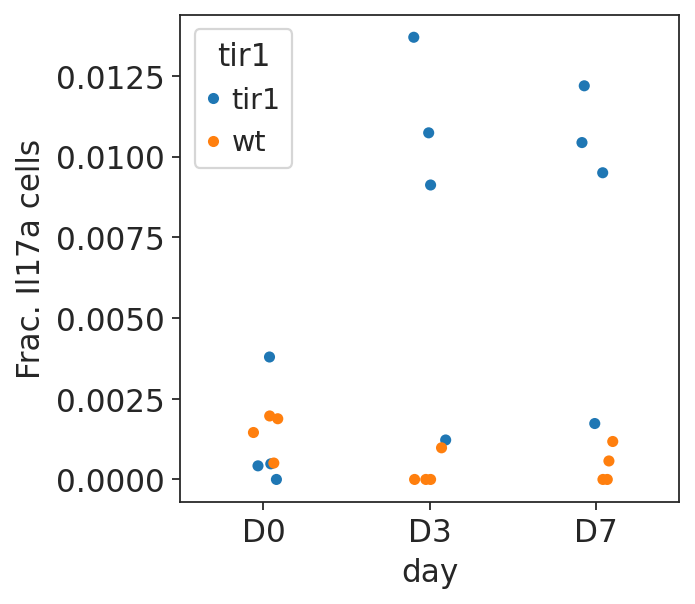

In [27]:
sns.stripplot(s, x='day', hue='tir1', y=cluster_with_il17)
plt.ylabel("Frac. Il17a cells")
plt.gcf().savefig('./FINAL_FIGURES/n_il17a.pdf', bbox_inches='tight')

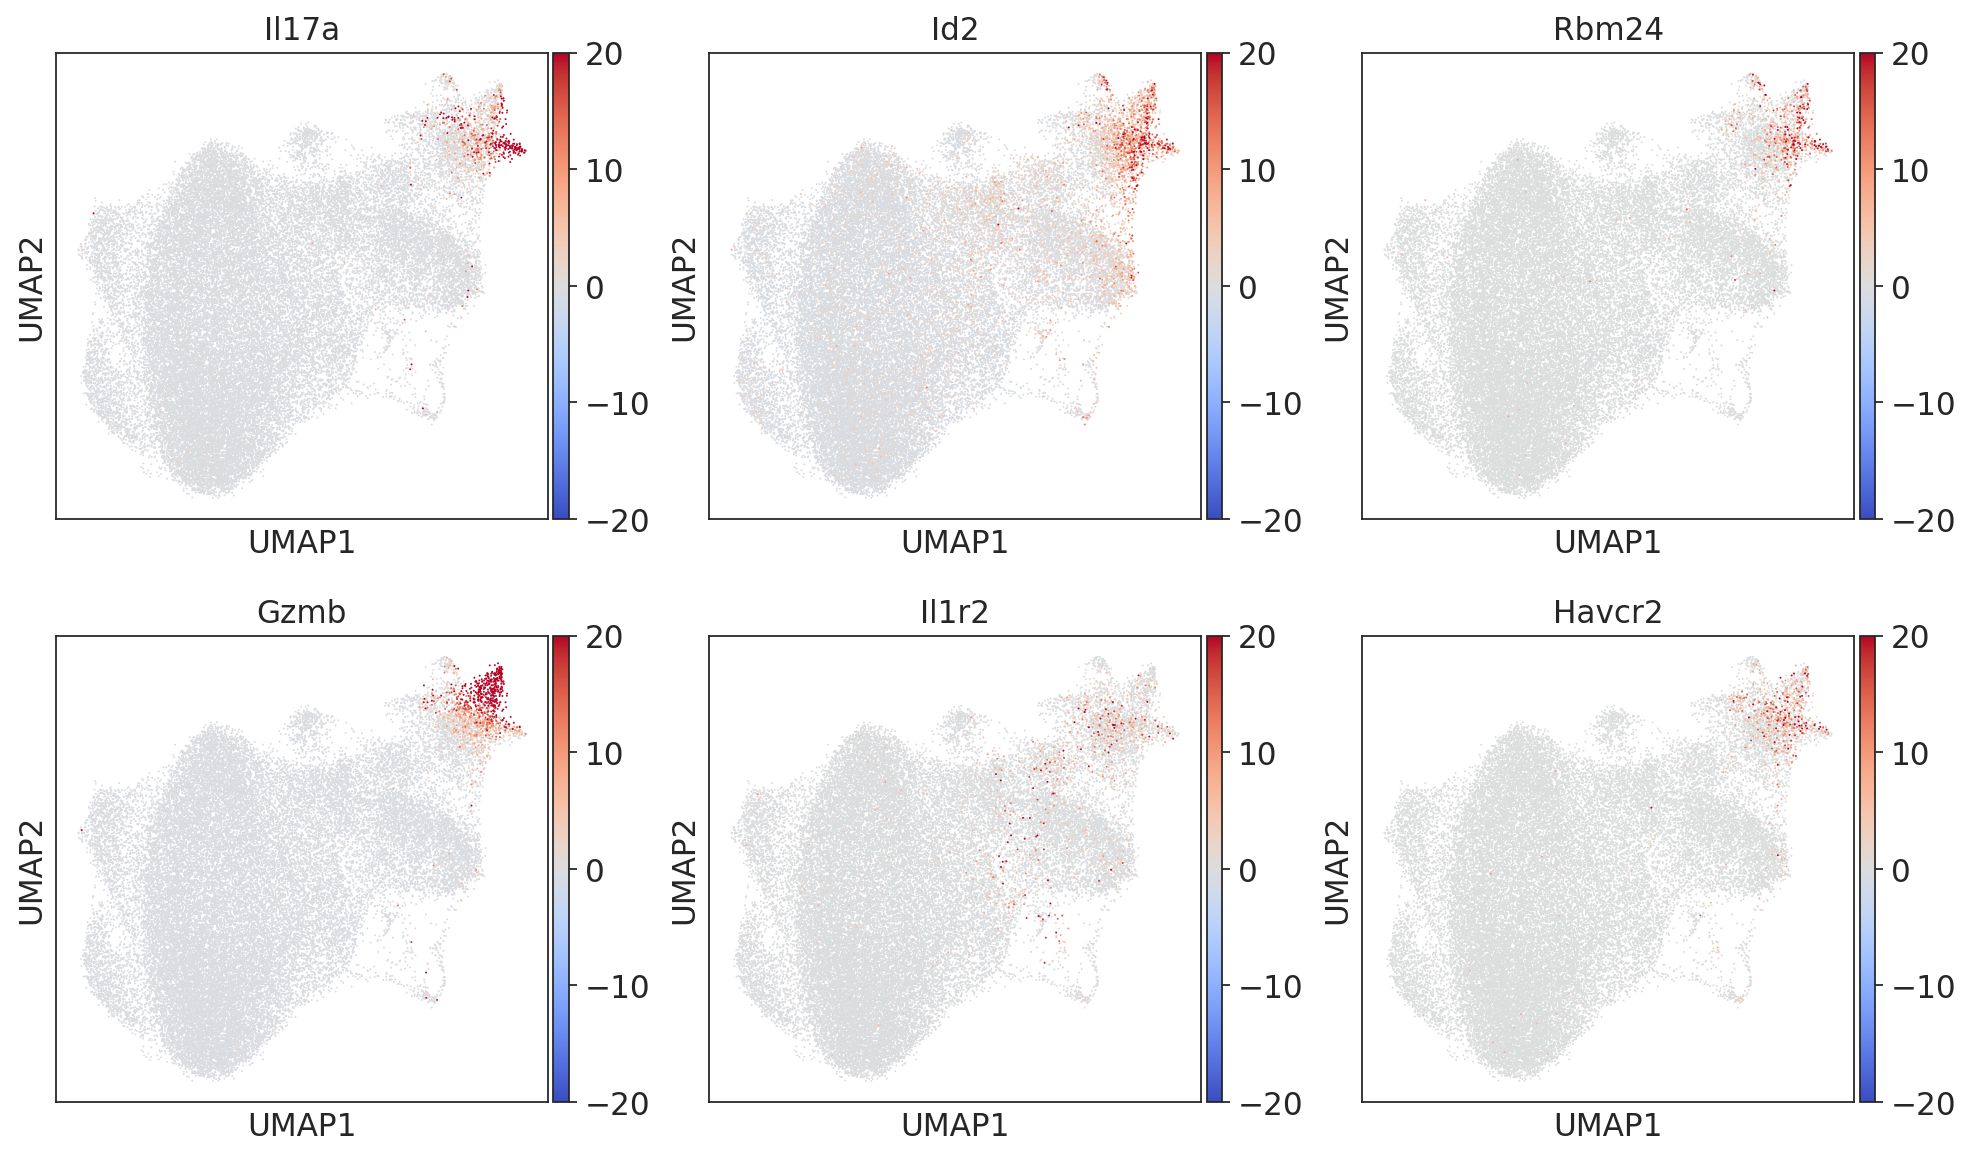

In [28]:
fig = sc.pl.umap(adata, color=['Il17a', 'Id2', 'Rbm24', 'Gzmb', 'Il1r2', 'Havcr2'], 
                 cmap='coolwarm', vmin=-20, vmax=20, ncols=3, return_fig=True)
fig.savefig('./FINAL_FIGURES/cluster_for_Il17a.pdf', bbox_inches='tight')
